# 原子で計算をおこなう

量子コンピューターのプログラミングは、今では誰もが自宅から快適におこなうことができます。

でも、何をどうやってつくるのでしょうか？そもそも量子プログラムとは？量子コンピューターとは何でしょうか？

これらの疑問は、今日の標準のデジタルコンピューターと比較することで回答できます。残念ながら、ほとんどの人は実際にデジタルコンピューターの動作を理解していません。この記事では、まずはデジタルコンピューターの基本原則から見ていきます。その後、量子コンピューティングの話にスムーズに移行できるよう、量子コンピューティング上での計算を行うときと同じツールを使用して実行します。

## Contents

1. [Splitting information into bits](#bits)    
2. [Computation as a Diagram](#diagram)    
3. [Your First Quantum Circuit](#first-circuit)    
4. [Example: Adder Circuit](#adder)       
  4.1 [Encoding an Input](#encoding)    
  4.2 [Remembering how to Add](#remembering-add)    
  4.3 [Adding with Qiskit](#adding-qiskit)     

Below is some Python code we'll need to run if we want to use the code in this page:

In [2]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram

### 1. 情報をビットに分割する

最初に知っておくべきことは、ビットの概念です。これらは、世界で最も単純なアルファベットになるように設計されています。 0と1の2文字だけで、あらゆる情報を表現できます。

例えば数字もそのひとつです。ヨーロッパ言語では、通常、数字は0、1、2、3、4、5、6、7、8、9の10桁の文字列を使用して表されます。この数字列では、それぞれが数字に含まれる回数を表します10のべき乗。たとえば、9213と書くと、



$$ 9000 + 200 + 10 + 3 $$



または、10の累乗を強調する方法で表現される


$$ (9\times10^3) + (2\times10^2) + (1\times10^1) + (3\times10^0) $$


通常、このシステムは番号10に基づいて使用しますが、他の番号に基づいたシステムも同様に簡単に使用できます。たとえば、2進数システムは2に基づいています。これは、2つの文字0と1を使用して、数値を2のべき乗の倍数として表現することを意味します。たとえば、9213は10001111111101になります。


$$ 9213  = (1 \times 2^{13}) + (0 \times 2^{12}) + (0 \times 2^{11})+ (0 \times 2^{10}) +(1 \times 2^9) + (1 \times 2^8) + (1 \times 2^7) \\\\ \,\,\,   + (1 \times 2^6) + (1 \times 2^5) + (1 \times 2^4) + (1 \times 2^3) + (1 \times 2^2) + (0 \times 2^1) + (1 \times 2^0) $$


ここでは、10、100、1000などではなく、2、4、8、16、32などの倍数として数値を表現しています。
<a id="binary_widget"></a>

In [2]:
from qiskit_textbook.widgets import binary_widget
binary_widget(nbits=5)

HTML(value='<pre>Binary   Decimal\n 00000 = 0</pre>')

バイナリ文字列として知られるこれらのビット文字列は、単なる数値以上のものを表すために使用できます。たとえば、ビットを使用してテキストを表現する方法があります。使用する任意の文字、数字、または句読点について、[この表](https://www.ibm.com/support/knowledgecenter/en/ssw_aix_72/network/conversion_table.html)を使用して、最大8ビットの対応するストリングを検索できます。変換コードは任意に定義されたものですが、広く合意された標準になっており、この記事をインターネット経由で送信するのにも使われています。

このようにしてすべての情報はコンピューターで表現されています。数字、文字、画像、音声のいずれであっても、すべてバイナリ文字列の形で存在します。

私たちの標準的なデジタルコンピューターのように、量子コンピューターはこの同じ基本的な考え方に基づいています。主な違いは、量子的に操作できるビットの変形である qubits を使用していることです。この教科書の残りの部分では、量子ビットとは何か、それらが何ができるか、どのようにそれを行うかを探ります。ただし、このセクションでは、量子についてはまったく話しません。そのため、量子ビットを通常のビットとして使用します。

### Quick Exercises
1. Think of a number and try to write it down in binary.
2. If you have $n$ bits, how many different states can they be in?

### 2. ダイアグラムを使った計算

量子ビットを使用する場合もビットを使用する場合も、入力を必要な出力に変換するためにそれらを操作する必要があります。少数のビット用の非常に単純なプログラムでは、このプロセスを「回路図」と呼ばれる図で表すと便利です。入力は左側にあり、出力は右側にあり、演算はその間の不可解な記号によって表されます。これらの演算に用いられる記号は、主に歴史的な背景から「ゲート」と呼ばれます。

標準的なビットベースのコンピューターでの回路の例を次に示します。これが具体的に何を意味するかまではわからなくて大丈夫です。これらの回路がどのようなものかのイメージだけを提供するものです。

![image1](images/classical_circuit.png)

量子コンピューターも基本的には同じ考え方ですが、入力、出力、および演算に使用される記号について異なる表現を使います。上記のビットベースのコンピューターで示した例と同じプロセスを表す量子回路を次に示します。

![image2](images/quantum_circuit.png)

このセクションの残りの部分では、回路の構築方法を説明します。最後に、上記の回路を作成する方法、それが何をするのか、なぜ有用なのかを理解します。

### 3. はじめての量子回路

量子回路を作成するには3つのステップが必要です。最初に入力をエンコードし、次に実際の計算を行い、最後に出力を抽出します。最初の量子回路では、これらの最後の仕事に焦点を当てます。まず、8つの量子ビットと8つの出力を持つ回路を作成します。

In [3]:
n = 8
n_q = n
n_b = n
qc_output = QuantumCircuit(n_q,n_b)

`qc_output` と呼ばれるこの回路は、`QuantumCircuit`を使用してQiskitによって作成されます。数値`n_q`は、回路内のキュービットの数を定義します。 `n_b`を使用して、最後に回路から抽出する出力ビット数を定義します。

量子回路の出力の抽出は、「測定」と呼ばれる操作を使用して行われます。各測定は、特定の量子ビットに対して特定の出力ビットを出力として与えるように伝えます。次のコードは、8つの量子ビットのそれぞれに「測定」操作を適用します。量子ビットとビットは両方とも0から7までの数字でラベル付けされています。コマンド`qc.measure（j、j）`は、回路`qc`に測定値を追加し、量子ビット`j`に出力をビット`j`に書き込むよう指示します。

In [4]:
for j in range(n):
    qc_output.measure(j,j)

それでは作成した回路の中身をみてみましょう。

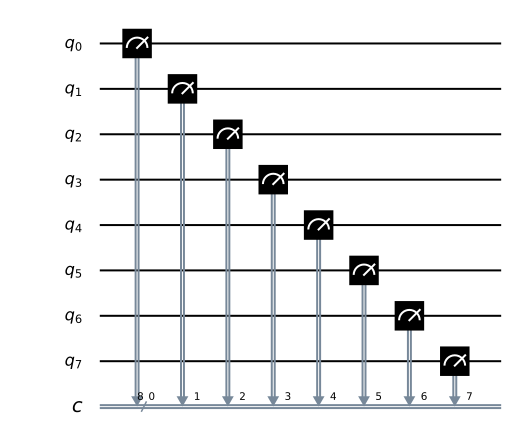

In [5]:
qc_output.draw()

量子ビットは常に出力が ```0```となるよう初期化されます。上記の回路は量子ビットに対して何の操作もしませんので、これらを測定したときに得られる結果もまた```0```です。これは回路を何度も実行し、結果をヒストグラムにプロットすることで確認できます。各量子ビットからの結果は常に```00000000```: a ```0```であることがわかります。

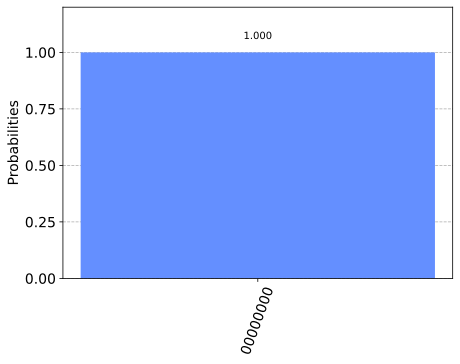

In [6]:
counts = execute(qc_output,Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

何回も実行して結果をヒストグラムとして表示する理由は、量子コンピューターの計算結果にランダム性が存在するためです。この場合は、何も量子的な計算を行っていないため、```00000000```の結果を確実に出力します。

この結果は、量子コンピューターの振る舞いを再現する古典コンピューターである量子シミュレーターから得られていることに注意してください。シミュレーションは少数の量子ビットに対してのみ可能ですが、それでも最初の量子回路を設計する際には非常に便利なツールです。実際の量子デバイスで実行するには ```Aer.get_backend（'qasm_simulator'）```を使用したいデバイスのバックエンドオブジェクトに置き換えるだけです。

### 4. 例：加算回路を作成する
#### 4.1 入力をエンコードする

次に、異なるバイナリ文字列を入力としてエンコードする方法を見てみましょう。このためには、NOTゲートと呼ばれるものが必要です。これは、コンピューターで実行できる最も基本的な操作です。ビット値を単純に反転します： ```0```は```1```になり、```1```は```0```になります。量子ビットの場合、NOTの仕事をする ```x```と呼ばれる操作です。

以下では、エンコードのジョブ専用の新しい回路を作成し、`qc_encode`と呼びます。ここではは量子ビットの数のみを指定します。

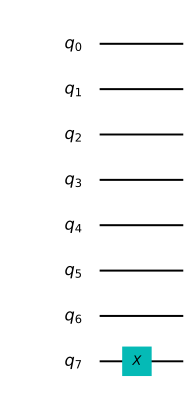

In [7]:
qc_encode = QuantumCircuit(n)
qc_encode.x(7)

qc_encode.draw()

結果の抽出は、以前つくった`qc_output`回路を使用して実行できます。 `qc_encode + qc_output`で2つの回路をつなぎあわせてれば、最後に追加された出力を抽出することができます。

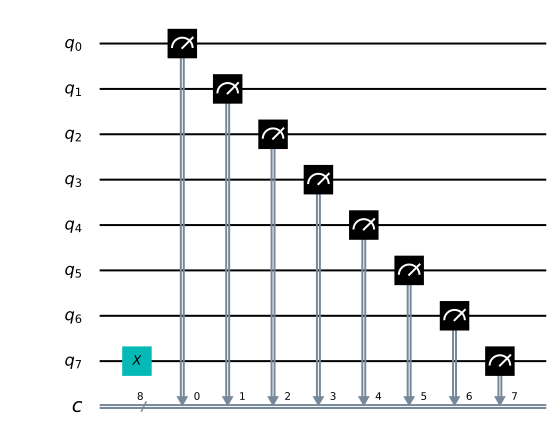

In [8]:
qc = qc_encode + qc_output
qc.draw(output='mpl',justify='none')

こうしてふたつの回路を組み合わせて実行して結果を表示させることができます。

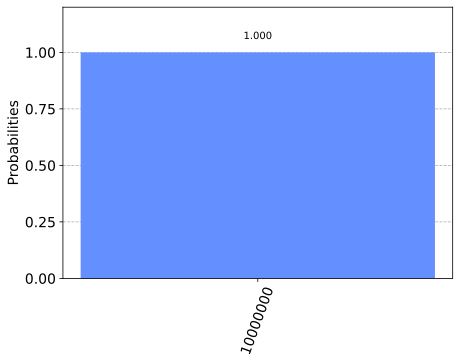

In [9]:
counts = execute(qc,Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

ご覧のとおり、今回は ```10000000``` という結果が出力されました。

反転したビットは、量子ビット7に由来し、文字列の左端にあります。これは、Qiskitが文字列のビットに左から右に番号を付けるためです。この慣習に違和感を覚えたなら、心配しないでください。文字列のビットにどういう順番で番号を付けるかは好みが分かれるところで、他の教科書だと違う方法で番頭を付けている場合もあるでしょう。Qiskitでは文字列のビットに左から右に番号を付けるということだけ覚えておいてください。いずれにせよ、量子ビットを使って数字を表す場合、Qiskitの方法には利点があります。なぜなら、私たちが慣れ親しんでいるバイナリ表現と同様に、qubit 7は、数に$2^7$がいくつあるかを示していることを意味するからです。つまり、qubit 7の反転（0→1)操作は、8ビットコンピューター上で128という数字をエンコードするのと同じことなのです。

次に、何か他の数字をエンコードしてみましょう。たとえば、あなたの年齢を表示させます。検索エンジンを使用して、年齢の数字がバイナリでどのように表現されるのかを調べて（「0b」が含まれている場合は無視、64歳未満の場合は左側に0を追加）からエンコードします。以下は34歳の年の数(1×$2^5$+1×$2^1$=34)をエンコードする例です。

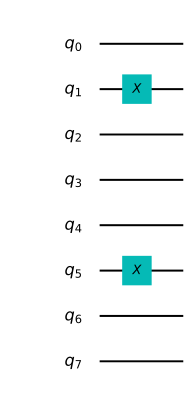

In [10]:
qc_encode = QuantumCircuit(n)
qc_encode.x(1)
qc_encode.x(5)

qc_encode.draw()

これでコンピューターへの情報のエンコードの仕方がわかりました。次はエンコードした情報の処理方法、エンコードした入力からのアウトプットの出力の仕方についてです。

#### 4.2 足し算の仕方を思い出してみよう

入力から出力を得るには、解く問題が必要です。基本的な算数からおさらいをしましょう。小学校で、比較的大きな数を足し算をするときは、扱いやすい大きさに分解しました。例えば：

```
   9213
+  1854
=  ????
```

ここでは 一桁ずつ右から順番に足していきます。まずは3+4
```
   9213
+  1854
=  ???7
```

そして 1+5
```
   9213
+  1854
=  ??67
```

つづいて 2+8=10  結果が2桁となったため、1を保持して次の桁に繰り上げを行う必要があります。

```
   9213
+  1854
=  ?067
   ¹ 
```

そして最後に 9+1+1=11を計算することで答えを求めることができます。

```
   9213
+  1854
= 11067
   ¹ 
```


これは単純な足し算の例かもしれませんが、すべてのアルゴリズムの基本的な原理を示しています。アルゴリズムが数学的な問題を解決するように設計されているか、テキストや画像を処理するように設計されているかに関係なく、私たちは常に大きなタスクを小さくシンプルなステップに分解します。

コンピューターで実行するには、アルゴリズムを可能な限り小さくて最も簡単な手順にコンパイルする必要があります。これらがどのように見えるかを見るために、上記の足し算の問題をもう一度、ただし今度はバイナリでやってみましょう。


```
   10001111111101
+  00011100111110
                                    
=  ??????????????
```

2番目の文字列の左端に余分な0がたくさんついていることに注目してください。これは、2つの文字列の長さを揃えるためです。

最初のタスクは、右端の1 + 0を実行することです。バイナリでは、任意の番号体系と同様に、答えは1です。2番目の列の0 + 1に対しても同じ結果が得られます。

```
   10001111111101
+  00011100111110

=  ????????????11 
```

次に1+1=2ですが、 バイナリでは、数値2は ```10```と記述されるため、2ビット必要です。つまり、10進数の10の場合と同様に、1を保持する必要があります。

```
   10001111111101
+  00011100111110
=  ???????????011 
             ¹ 
```

次の桁では```1+1+1```を計算します. 三個の数を合計する必要があるのでコンピューターにとってはやや複雑な処理になってきました。しかしこれも毎回二個のビットの足し算という、より単純なオペレーションにコンパイルすることができます。 まずは最初の二つの1から足していきます。

```
   1
+  1
= 10
```

つづいて、この ```10```と最後の```1```を足す必要があります。これは、いつも通りそれぞれ同じ長さの文字列として並べて上下を足すことで実行できます。

```
  10
+ 01
= 11
```

答えは ```11```（3としても知られています）です。

ここで残りの問題に戻ることができます。 上記の答え```11```には、新たなキャリービットがあります。

```
   10001111111101
+  00011100111110
=  ??????????1011
            ¹¹
```

ここで再び1 + 1 + 1を行う必要がでてきました。しかし、私たちはすでにこの問題の解き方を知っていますので、大したことではありません。

実はここから先の問題の解き方を我々はすでに知っています。残っている桁の計算を二つのビットの足し算に分解すると、計算が必要な組合せは四つしかないためです。 四つの計算結果を次に示します（一貫性を保つために、すべての回答を2ビットで記述します）。

```
0+0 = 00 (in decimal, this is 0+0=0)
0+1 = 01 (in decimal, this is 0+1=1)
1+0 = 01 (in decimal, this is 1+0=1)
1+1 = 10 (in decimal, this is 1+1=2)
```

これは半加算器(*half adder*)と呼ばれています。私たちが量子ビットでつくるコンピューターも、この半加算器さえ実装できれば、それらをつなぎ合わせることでどのような数でも足すことができるようになるのです。

#### 4.3 Qiskitで足し算を行う

それでは、Qiskitを使って独自の半加算器を作成してみましょう。この回路には、入力をエンコードする部分、アルゴリズムを実行する部分、および結果を抽出する部分が含まれます。最初の入力をエンコードする部分は、新しい入力を使用するたびに変更する必要がありますが、残りは常に同じままです。

![image3](https://s3.us-south.cloud-object-storage.appdomain.cloud/strapi/04498f84a69d4e859afd19b2760ced24atoms6.png)


足し合わせる2つのビットは、量子ビット0(`q[0]`)と1(`q[1]`)にそれぞれエンコードされます。上記では、それぞれの量子ビットに ```1```がエンコードされ、```1 + 1```の解を見つけようとしています。結果は2ビットの文字列になり、量子ビット2(`q[2]`)および量子ビット3(`q[3]`)から読み取ります。 残されているのは中央の空白スペースに実際のプログラムを埋めることだけです。

画像の破線は、回路のさまざまな部分を区別するためのものです（ただし、より興味深い用途もあります）。それらは `barrier`コマンドを使用して作成されます。

コンピューティングの基本操作は、論理ゲートで行われます。これまでに回答を手動で書き出すためにNOTゲートを使いましたが、半加算器を作成するのにはこれだけでは十分ではありません。コンピューターに実際の計算を行わせるには、さらに強力なゲートが必要になります。

どのようなゲートが必要になってくるのかをみるために、半加算器がすべきことをもう一度見てみましょう。

```
0+0 = 00
0+1 = 01
1+0 = 01
1+1 = 10
```

これら4つの答えすべての右端のビットは、足し合わせる2つのビットが同じか異なるかによって決定されます。そのため、2つのビットが等しい「0 + 0」と「1 + 1」の場合、答えの右端のビットが「0」になります。異なるビットを足し合わせる「0 + 1」と「1 + 0」の場合、右端のビットは「1」です。

この論理を再現するには、2つのビットが異なるかどうかを判断できるものが必要です。従来、デジタルコンピューティングの研究では、これはXORゲートで実現できます。

量子コンピューティングにおいては, XORゲートの仕事は制御NOTゲートが行います。長い名前なので、通常は単にCNOTと呼びます。 Qiskitでは更に短く ```cx```と記述します。回路図の中では、下図のように描かれています。

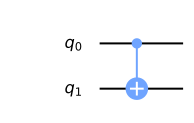

In [11]:
qc_cnot = QuantumCircuit(2)
qc_cnot.cx(0,1)
qc_cnot.draw()

これは、２量子ビットに適用されます。 1つは制御量子ビットとして機能します（これは小さなドットのあるものです）。もう1つは（大きな円で）*ターゲット量子ビット*として機能します。

CNOTの効果を説明する方法はいくつかあります。 一つは、2つの入力ビットを調べて、それらが同じか異なるかを確認することです。次に、ターゲット量子ビットに回答を書き込みます。２つの入力ビットが同じ場合はターゲットは ```0```になり、異なる場合は``` 1```になります。

CNOTを説明する別の方法は、コントロールが ```1```の場合、ターゲットに対してNOTを行い、それ以外は何もしないと言うことです。この説明は、前の説明同様に有効です（ゲートの名前もここからつけられています）。

可能な入力をそれぞれ試して、CNOTを試してみてください。たとえば、入力 ```01```でCNOTをテストする回路を次に示します。

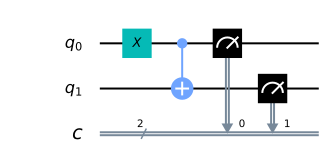

In [12]:
qc = QuantumCircuit(2,2)
qc.x(0)
qc.cx(0,1)
qc.measure(0,0)
qc.measure(1,1)
qc.draw()

この回路を実行すると、出力が ```11```であることがわかります。次のいずれかの理由からそうなることが考えられます。

- CNOTは入力値が互いに異なることを検出して ```1```を出力しています。これは、量子ビット1の状態（ビット列の左側にあることを思い出してください）を上書きし、 ```01```を ```11```に変換することで行います。

- CNOTは、量子ビット0が状態 ```1```であることを確認し、量子ビット1にNOTを適用します。これにより、量子ビット1の```0```が ```1```に変換されます。そして、```01```を``` 11```に変換します。

半加算器の場合、いずれの入力も結果で上書きしたくありません。そこで結果を異なる量子ビットのペアに書き込みたいと思います。これは2つのCNOTを使用することで実現できます。

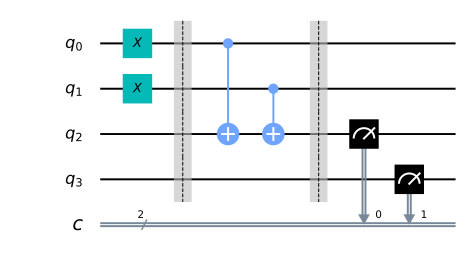

In [13]:
qc_ha = QuantumCircuit(4,2)
# encode inputs in qubits 0 and 1
qc_ha.x(0) # For a=0, remove this line. For a=1, leave it.
qc_ha.x(1) # For b=0, remove this line. For b=1, leave it.
qc_ha.barrier()
# use cnots to write the XOR of the inputs on qubit 2
qc_ha.cx(0,2)
qc_ha.cx(1,2)
qc_ha.barrier()
# extract outputs
qc_ha.measure(2,0) # extract XOR value
qc_ha.measure(3,1)

qc_ha.draw()

半加算器の完成まであと半分の道のりとなりました。出力のもう1つのビット、つまり、量子ビット3が残っています。

可能な足し算の４つの答えをもう一度見ると、量子ビット3が ```0```ではなく```1```であるケースが1つ： ```1 + 1``` = ```10```しかないことに気付くでしょう。追加するビットが両方とも```1```の場合にのみ発生します。

つまり、両方の入力が ```1```であるかどうかをコンピューターに確認させることでこの部分を計算することができます。両方の入力が```1```である場合のみ、量子ビット3でNOTゲートを実行する必要があります。

このためには、新しいゲートが必要です。CNOTのようですが、制御量子ビットが1つではなく2つになります。これは、両方の制御量子ビットの状態が ```1```の場合にのみ、ターゲット量子ビットに対してNOTを実行します。この新しいゲートは*Toffoli（トフォリ）*と呼ばれ、ブール論理ゲート上のANDゲートに相当します。

QiskitではToffoliは `ccx` というコマンドで実装されます。

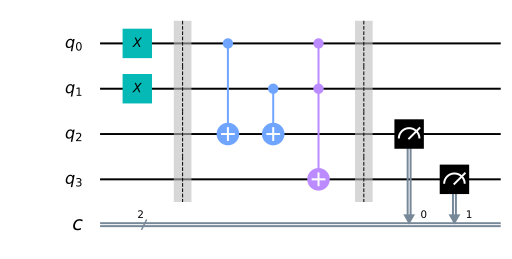

In [14]:
qc_ha = QuantumCircuit(4,2)
# encode inputs in qubits 0 and 1
qc_ha.x(0) # For a=0, remove the this line. For a=1, leave it.
qc_ha.x(1) # For b=0, remove the this line. For b=1, leave it.
qc_ha.barrier()
# use cnots to write the XOR of the inputs on qubit 2
qc_ha.cx(0,2)
qc_ha.cx(1,2)
# use ccx to write the AND of the inputs on qubit 3
qc_ha.ccx(0,1,3)
qc_ha.barrier()
# extract outputs
qc_ha.measure(2,0) # extract XOR value
qc_ha.measure(3,1) # extract AND value

qc_ha.draw()

この例では、2つの入力ビットが両方とも「1」であるため、「1 + 1」を計算しています。何が得られるか見てみましょう。

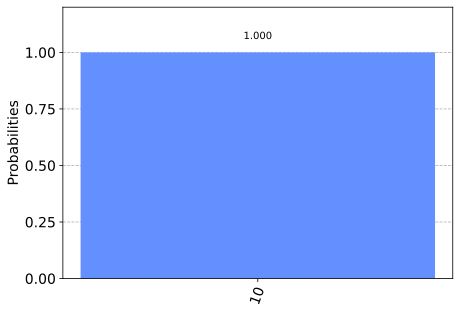

In [15]:
counts = execute(qc_ha,Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

結果は「2」のバイナリ表現である「10」です。有名な数学的問題 1+1 を解決できるコンピューターを構築しました！

ここで残る3つの足し算の入力で同じ事を試してみると、アルゴリズムがそれらに対しても正しい結果を与えることを示すことができます。

半加算器は足し算に必要な要素をすべて含んでいます。NOT, CNOTそしてToffoliゲートを用いることで、どのような大きさの数字の組合せでも足し合わせることができるプログラムを構築することができます。

この3つのゲートは、足し算だけでなくコンピューティングにおけるすべてを行うのに十分です。実際、CNOTなしでも実行できます。値が「1」のビットを作るために本当に必要なのはNOTゲートだけです。Toffoliゲートは本質的には数学の世界における原子のようなもので、すべての問題解決手法をコンパイルできる最も単純な要素と言えます。

このように、量子計算は原子を分割して行っていきます。

In [16]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.13.0',
 'qiskit-aer': '0.5.0',
 'qiskit-ignis': '0.3.0',
 'qiskit-ibmq-provider': '0.6.0',
 'qiskit-aqua': '0.6.5',
 'qiskit': '0.18.0'}